In [1]:
import cv2
import numpy as np
from scipy import ndimage
import numba
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import copy

In [39]:
report_imgdir = "../../report/images/"

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
report_imgdir = "../../report/images/"

In [3]:
@numba.njit
def minimal_energy_forward_ttb(M, CU, CL, CR, height, width):
  """
  Compute the minimal energy matrix (measuring energy to go from Top To Bottom, 
  hence 'ttb') for the forward energy algorithm. 
  """
  # populate accumulated energy matrix M using dynamic programming
  for i in range(1, height):
    for j in range(width):
      if j == 0:
        M[i, j] += min(M[i-1, j] + CU[i, j], 
                       M[i-1, j+1] + CR[i, j])
      elif j == width-1:
        M[i, j] += min(M[i-1, j-1] + CL[i, j], 
                       M[i-1, j] + CU[i, j])
      else:
        M[i, j] += min(M[i-1, j-1] + CL[i, j], 
                       M[i-1, j] + CU[i, j], 
                       M[i-1, j+1] + CR[i, j])
  return M

@numba.njit
def minimal_energy_backward_ttb(M, height, width):
  """
  Compute the minimal energy matrix (measuring energy to go from Top To Bottom, 
  hence 'ttb') for the backward energy algorithm. 
  """
  # populate accumulated energy matrix M using dynamic programming
  for i in range(1, height):
    for j in range(width):
      if j == 0:
        M[i, j] += min(M[i-1, j], M[i-1, j+1])
      elif j == width-1:
        M[i, j] += min(M[i-1, j-1], M[i-1, j])
      else:
        M[i, j] += min(M[i-1, j-1], M[i-1, j], M[i-1, j+1])
  return M

def forward_energy(img):
  height, width = img.shape[:2]
  channels = img.shape[2] if len(img.shape) == 3 else 1

  # convert to grayscale or do nothing if it already is
  if channels == 3 and img.dtype == np.uint8:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
  else:
    gray = img
  # squeeze in case dims are (H,W,1) and change datatype to avoid saturations
  gray = np.squeeze(gray).astype(np.float64)
  energy = np.zeros((height, width))
  M = np.zeros((height, width))
  CU = np.zeros((height, width))
  CL = np.zeros((height, width))
  CR = np.zeros((height, width))
  
  CU = np.abs(ndimage.convolve(gray, np.array([[-1, 0, 1]]), mode="constant"))
  CL = CU + np.abs(ndimage.convolve(gray, np.array([[0, 1, 0],[-1, 0, 0]]), mode="constant"))
  CR = CU + np.abs(ndimage.convolve(gray, np.array([[0, 1, 0],[0, 0, -1]]), mode="constant"))
  M[0,:] = np.amin(np.vstack((CU[0,:], CL[0,:], CR[0,:])), axis=0)
  
  return minimal_energy_forward_ttb(M, CU, CL, CR, height, width)

def backward_energy(img):
  height, width = img.shape[:2]
  channels = img.shape[2] if len(img.shape) == 3 else 1

  # convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if channels == 3 else img
  # squeeze in case dims are (H,W,1) and change datatype to avoid saturations
  gray = np.squeeze(gray).astype(np.float64)

  # compute gradients
  xgrad = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  ygrad = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
  M = np.sqrt(xgrad**2 + ygrad**2)
  return minimal_energy_backward_ttb(M, height, width)

def find_seam(img, M):
  height, width = img.shape[:2]
  # backtrack the matrix to find the indexes that make up the seam
  seam_signature = np.ones((height, width), dtype=np.bool)
  j = int(np.argmin(M[-1, :]))
  seam_signature[-1, j] = False
  seam_idx = [j]
  for i in range(height-2, -1, -1):
    upleft = float("inf") if j == 0 else M[i, j-1]
    upcenter = M[i, j]
    upright = float("inf") if j == width-1 else M[i, j+1]
    j += int(np.argmin([upleft, upcenter, upright])) - 1
    seam_signature[i, j] = False
    seam_idx.append(j)
  seam_idx.reverse()

  return np.array(seam_idx), seam_signature

def delete_seam(img, seam_signature):
  height, width = img.shape[:2]
  channels = img.shape[2] if len(img.shape) == 3 else 1
  return img[seam_signature].reshape((height, width-1, channels))
    
@numba.njit
def insert_seam(img, seam_idx):
  height, width = img.shape[:2]
  channels = img.shape[2] if len(img.shape) == 3 else 1
  
  outimg = np.zeros((height, width + 1, channels), dtype=np.uint8)
  for i in range(height):
    j = seam_idx[i]
    if j == 0: # leftmost column
      newpixel = img[i, j:j+2].mean()
      outimg[i, j] = newpixel
      outimg[i, j+1:] = img[i, j:]
    elif j == width - 1: # rightmost column
      newpixel = img[i, j-1:j+1].mean()
      outimg[i, :j] = img[i, :j]
      outimg[i, j] = newpixel
      outimg[i, j+1:] = img[i, j:]
    else:
      newpixel = img[i, j-1:j+2].mean()
      outimg[i, :j] = img[i, :j]
      outimg[i, j] = newpixel
      outimg[i, j+1:] = img[i, j:]
  
  return outimg
  
def seam_carve(img, dx, dy, mask=None, use_forward_energy=True):  
  """Method for image resizing maintaing the aspect of the content but not the 
  image's aspect ratio itself. Regular resizing to a new aspect ratio creates 
  distortions on the contents of the image. This is not the case with Seam Carving 
  Resizing. Seam Carving prioritizes less important regions of an image when 
  removing pixels, maintaining the rest intact. This is an implementation (using 
  openCV and scikit-image) of the paper "Seam Carving for Content-Aware Image 
  Resizing" by Avidan and Shamir from Mitsubishi Electric Research Labs (MERL).
  """
  
  energyfn = forward_energy if use_forward_energy else backward_energy

  # delete horizontal seams
  if dx < 0: 
    for _ in range(abs(dx)):
      M = energyfn(img)
      seam_idxs, seam_signature = find_seam(img, M)
      img = delete_seam(img, seam_signature)
  # insert horizontal seams
  elif dx > 0: 
    for _ in range(abs(dx)):
      M = energyfn(img)
      seam_idxs, seam_signature = find_seam(img, M)
      img = insert_seam(img, seam_idxs)

  # delete vertical seams
  if dy < 0: 
    img = np.rot90(img, 1)
    for _ in range(abs(dy)):
      M = energyfn(img)
      seam_idxs, seam_signature = find_seam(img, M)
      img = delete_seam(img, seam_signature)
    img = np.rot90(img, -1)
  # insert vertical seams
  elif dy > 0: 
    img = np.rot90(img, 1)
    for _ in range(abs(dy)):
      M = energyfn(img)
      seam_idxs, seam_signature = find_seam(img, M)
      img = insert_seam(img, seam_idxs)
    img = np.rot90(img, -1)

  return img

In [6]:
def plot_seam_carving_result(image_file, dx, dy):
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res_img_forward = seam_carve(img, dx, dy)
    res_img_backward = seam_carve(img, dx, dy, use_forward_energy=False)

    fig, axs = plt.subplots(3, 2, figsize=(8,9))
    axs[0, 0].set_title("Input image")
    axs[0, 0].imshow(img)
    M = backward_energy(img)

    axs[0, 1].axis('off')

    axs[1, 0].set_title("Backward energy")
    axs[1, 0].imshow(M, cmap=cm.gray)

    axs[1, 1].set_title("Resized using backward energy")
    axs[1, 1].imshow(res_img_backward, cmap=cm.gray)

    axs[2, 0].set_title("Forward energy")
    M = forward_energy(img)
    axs[2, 0].imshow(M, cmap=cm.gray)

    axs[2, 1].set_title("Resized using forward energy")
    axs[2, 1].imshow(res_img_forward, cmap=cm.gray)
    plt.autoscale(enable=False)
    fig.tight_layout()
    plt.show()
    report_pgf_filename = "seam_carved_{}.pgf".format(image_file.split(".")[0])
    plt.savefig(report_imgdir + report_pgf_filename)

image_file = "bench.png"
plot_seam_carving_result(image_file, -200, 0)

error: OpenCV(4.5.1-dev) /home/david/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


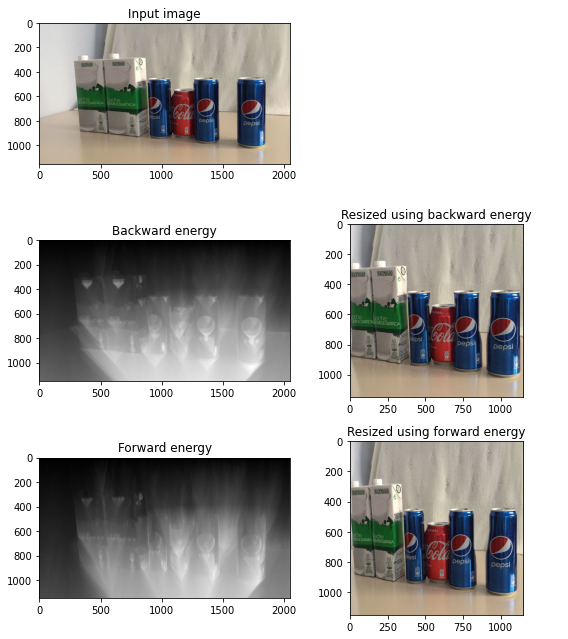

<Figure size 432x288 with 0 Axes>

In [11]:
image_file = "../img/hidden_cocacola2.jpeg"
plot_seam_carving_result(image_file, -900, 0)

## Dynamic programming: small example

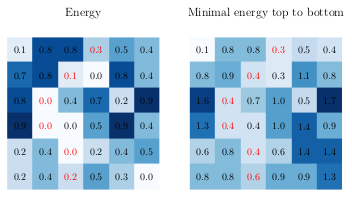

In [11]:
fig, axs = plt.subplots(1, 2)

energy = np.array(
    [
        [0.1, 0.8, 0.8, 0.3, 0.5, 0.4],
        [0.7, 0.8, 0.1, 0.0, 0.8, 0.4],
        [0.8, 0.0, 0.4, 0.7, 0.2, 0.9],
        [0.9, 0.0, 0.0, 0.5, 0.9, 0.4],
        [0.2, 0.4, 0.0, 0.2, 0.4, 0.5],
        [0.2, 0.4, 0.2, 0.5, 0.3, 0.0]
    ]
)
height, width = energy.shape[:2]
minimal_energy_ttb = np.array(
    [
        [0.1, 0.8, 0.8, 0.3, 0.5, 0.4],
        [0.8, 0.9, 0.4, 0.3, 1.1, 0.8],
        [1.6, 0.4, 0.7, 1.0, 0.5, 1.7],
        [1.3, 0.4, 0.4, 1.0, 1.4, 0.9],
        [0.6, 0.8, 0.4, 0.6, 1.4, 1.4],
        [0.8, 0.8, 0.6, 0.9, 0.9, 1.3]
    ]
)
path = [3, 2, 1, 1, 2, 2]

axs[0].matshow(energy, cmap=plt.cm.Blues)
axs[0].set_title("Energy")
axs[0].set_axis_off()
axs[1].matshow(minimal_energy_ttb, cmap=plt.cm.Blues)
axs[1].set_title("Minimal energy top to bottom")
axs[1].set_axis_off()

for i in range(height):
    for j in range(width):
        if i == path[j]:
            color = 'red'
        else:
            color = 'black'
        c = energy[j,i]
        axs[0].text(i, j, str(c), va='center', ha='center', color=color)
        c = minimal_energy_ttb[j,i]
        axs[1].text(i, j, str(c), va='center', ha='center', color=color)

# plt.savefig(report_imgdir + "dynprog_example.pgf")